In [ ]:
#By: Nithin Raj Rangaraj

In [12]:
from bs4 import BeautifulSoup
import re
import time
import requests
import pandas as pd

from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service

In [2]:
my_headers = { 'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'}

In [13]:
m_name=[]
movie=[]

#pages = 10
#for k in range(1,pages+1):    
page = 'https://www.rottentomatoes.com/browse/movies_at_home/sort:popular?page=5'
src  = False
for i in range(1,11): 
    try:
        response = requests.get(page, headers = my_headers)
        src = response.content
        break 
    except:
        print ('failed attempt #',i)
        time.sleep(2)
if not src:
    print('Could not get page: ', page)
else:
    print('Successfully got page: ', page)
soup = BeautifulSoup(src.decode('ascii', 'ignore'), 'lxml')
movieName = soup.findAll('span', {'class':re.compile('p--small')})
for m in movieName:
    c = m.get_text().strip()
    m_name.append(c)
n = 5
del m_name[:n]
for i in m_name:
    x = str(i)
    z = x.replace(" ","_").replace("'","").replace(':','').replace('.','').replace('?','').replace('!','').replace('-','_').replace('/','_').replace(',','').replace('&','')
    l = z.lower()
    movie.append(l)





Successfully got page:  https://www.rottentomatoes.com/browse/movies_at_home/sort:popular?page=5


In [17]:
path = "chromedriver_win32/chromedriver"
s = Service(path)
browser = webdriver.Chrome(service=s)

def check_exists_by_xpath(xpath):
    try:
        browser.find_element(By.XPATH,xpath)
    except NoSuchElementException:
        return False
    return True
# Defining Parameters (Movies list )

pageNum = 10

# Creating empty lists for each atrtibute
critic_1 = []
rating_1 = []
source_1 = []
text_1 = []
date_1 = []


hw_dataset = "C:/Users/parth/Downloads/Web lecs/H3_Dataset.csv"

# Opening the movie urls

for x in movie:
    browser.get("https://www.rottentomatoes.com/m/"+x+"/reviews")
    time.sleep(2)
    
    # for each page 
    for p in range(0,pageNum): 
        
        # parse the html 
        page_source = browser.page_source
        soup = BeautifulSoup(page_source, 'lxml')
        
        # get all the review divs
        reviews=soup.findAll('div', {'class':re.compile('review_table_row')})
        
        # grab the information for each review
        for review in reviews:
            
            # 1. if there is critic name information, get it
            criticChunk=review.find('a',{'href':re.compile('/critics/')})
            if criticChunk: 
                critic=criticChunk.text.strip()
                
            if critic=='':
                    critic='NA'

            # 2. if there is rating information, get it
            ratingChunk=reviews[0].find('div',{'class':re.compile('review_icon icon small')})
            if ratingChunk: 
                rating=ratingChunk.attrs['class'][-1]
            
            if rating=='':
                rating='NA'
        
            # 3. if there is source information, get it
            sourceChunk=review.find('em',{'class':re.compile('subtle critic-publication')})
            if sourceChunk: 
                source=sourceChunk.text.strip()
                
            if source=='':
                source='NA'
            
            # 4. if there is text information, get it    
            textChunk=review.find('div',{'class':re.compile('the_review')})
            if textChunk: 
                text=textChunk.text.strip()
            
            if text=='':
                text='NA'
            
            # 5. if there is date information, get it    
            dateChunk=review.find('div',{'class':re.compile('review-date subtle small')})
            if dateChunk: 
                date=dateChunk.text.strip()
                
            if date=='':
                date='NA'
            # Saving scraped data to lists
            critic_1.append(critic)
            rating_1.append(rating)
            source_1.append(source)
            text_1.append(text)
            date_1.append(date)  
                    
        # move to the next page by clicking on the "next" button
        if (check_exists_by_xpath('//button[@class="js-prev-next-paging-next btn prev-next-paging__button prev-next-paging__button-right"]')):
            browser.find_element(By.XPATH,'//button[@class="js-prev-next-paging-next btn prev-next-paging__button prev-next-paging__button-right"]').click()
            time.sleep(1)
        else:
            break
#browser.close()         

            
     


In [18]:
movies_data = {'Critics':critic_1,'Ratings':rating_1,'Sources':source_1,'Texts':text_1,'Dates':date_1}

movies_df = pd.DataFrame(movies_data)
movies_df

,Critics,Ratings,Sources,Texts,Dates
0,Alan French,rotten,Sunshine State Cineplex,"When your film becomes about everything, its a...","Nov 15, 2022"
1,Carey-Ann Pawsey,rotten,Orca Sound,It is deliberately opaque. Hard to read or fig...,"Nov 13, 2022"
2,Dallas King,rotten,Flick Feast,Ultimately it does not matter how pretty the h...,"Nov 13, 2022"
3,Jason Adams,rotten,My New Plaid Pants,Ultimately middling,"Nov 8, 2022"
4,Jorge Loser,rotten,Espinof,Layered; a nightmare rooted in a reality that ...,"Nov 7, 2022"
...,...,...,...,...,...
12581,Bill Goodykoontz,rotten,Arizona Republic,A movie for those who like to see directors ta...,"May 17, 2022"
12582,Scott Greenstone,rotten,Seattle Times,Garland has yet again created something singul...,"May 17, 2022"
12583,Christian Toto,rotten,HollywoodInToto.com,Director Alex Garland pushes past woke narrati...,"May 17, 2022"
12584,Matt Oakes,rotten,Silver Screen Riot,Both of Garland’s first two features matched s...,"May 17, 2022"


In [19]:
# Building Classifier

# Adding Review Class Column in Dataframe
def review_class(Ratings):
    
    if Ratings == 'rotten':
        return 'Negative'
    elif Ratings =='fresh':
        return 'Positive'
    else:
        return 'NA'

movies_df['Ratings_Class'] = movies_df['Ratings'].apply(review_class)

movies_df

,Critics,Ratings,Sources,Texts,Dates,Ratings_Class
0,Alan French,rotten,Sunshine State Cineplex,"When your film becomes about everything, its a...","Nov 15, 2022",Negative
1,Carey-Ann Pawsey,rotten,Orca Sound,It is deliberately opaque. Hard to read or fig...,"Nov 13, 2022",Negative
2,Dallas King,rotten,Flick Feast,Ultimately it does not matter how pretty the h...,"Nov 13, 2022",Negative
3,Jason Adams,rotten,My New Plaid Pants,Ultimately middling,"Nov 8, 2022",Negative
4,Jorge Loser,rotten,Espinof,Layered; a nightmare rooted in a reality that ...,"Nov 7, 2022",Negative
...,...,...,...,...,...,...
12581,Bill Goodykoontz,rotten,Arizona Republic,A movie for those who like to see directors ta...,"May 17, 2022",Negative
12582,Scott Greenstone,rotten,Seattle Times,Garland has yet again created something singul...,"May 17, 2022",Negative
12583,Christian Toto,rotten,HollywoodInToto.com,Director Alex Garland pushes past woke narrati...,"May 17, 2022",Negative
12584,Matt Oakes,rotten,Silver Screen Riot,Both of Garland’s first two features matched s...,"May 17, 2022",Negative


<AxesSubplot:>

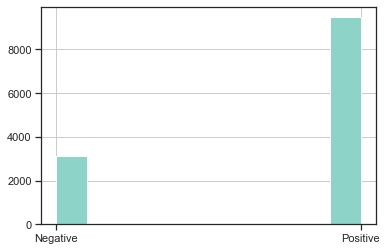

In [33]:
movies_df['Ratings_Class'].hist()

In [36]:
r_list = list(movies_df['Ratings_Class'])
p_count = r_list.count('Positive')
n_count = r_list.count('Negative')
print(p_count + n_count)

12586


In [20]:
hw_dataset = "C:/Users/parth/Downloads/Web lecs/H3_Dataset.csv"
rating_classlist = list(movies_df['Ratings_Class'])
with open(hw_dataset,'w',encoding='utf-8') as fw:               
    header = 'Critic' + ',' +'Rating'+ ',' +'Source'+ ',' + 'Text'+','+'Ratings_class'+ ','+'Date\n'
    fw.write(header)
    for l in range(len(critic_1)):
        cr = str(critic_1[l]).replace(',','')
        ra = str(rating_1[l])
        so = str(source_1[l]).replace(',','')
        te = str(text_1[l]).replace('\t','').replace('\n','').replace(',','')
        ra_c = str(rating_classlist[l])
        da = str(date_1[l]).replace(',','')
        review_data = cr + ',' + ra + ',' + so + ',' + te + ','+ ra_c + ',' + da + '\n'
        fw.write(review_data)   

In [78]:
# Import pandas to read in data
import numpy as np
import pandas as pd

# Import models and evaluation functions
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
#from sklearn import cross_validation
#from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

# Import vectorizers to turn text into numeric
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Import plotting
import matplotlib.pylab as plt
%matplotlib inline
# Importing Packages


# Import decision trees and logistic regression
from sklearn.tree import DecisionTreeClassifier


# Import train, test, and evaluation functions
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='ticks', palette='Set3')

In [79]:
X_text = movies_df['Texts']
Y = movies_df['Ratings_Class']

# Create a vectorizer that will track text as binary features
binary_vectorizer = CountVectorizer(binary=True)

# Let the vectorizer learn what tokens exist in the text data
binary_vectorizer.fit(X_text)

# Turn these tokens into a numeric matrix
X = binary_vectorizer.transform(X_text)

X

<12586x18589 sparse matrix of type '<class 'numpy.int64'>'
	with 271902 stored elements in Compressed Sparse Row format>

In [80]:
import random
random.seed(9001)



X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.80)

logistic = LogisticRegression()

logistic.fit(X_train, Y_train)
Y_test_predicted = logistic.predict(X_test)
acc = accuracy_score(Y_test_predicted, Y_test)
print("The accuracy is " + str(acc))    



The accuracy is 0.7688641779189833


C:\Users\parth\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [81]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(Y_test, Y_test_predicted))
print(classification_report(Y_test, Y_test_predicted))

[[ 190  416]
 [ 166 1746]]
              precision    recall  f1-score   support

    Negative       0.53      0.31      0.40       606
    Positive       0.81      0.91      0.86      1912

    accuracy                           0.77      2518
   macro avg       0.67      0.61      0.63      2518
weighted avg       0.74      0.77      0.75      2518



In [82]:
movies_df1 = pd.DataFrame(X_test, columns=['Texts'])
predictedReview1_df = movies_df1.assign(predictions=Y_test_predicted )

predictedReview1_df.head(15)

,Texts,predictions
0,"(0, 111)\t1\n (0, 578)\t1\n (0, 898)\t1\n ...",Positive
1,"(0, 294)\t1\n (0, 769)\t1\n (0, 964)\t1\n ...",Negative
2,"(0, 655)\t1\n (0, 769)\t1\n (0, 1675)\t1\n...",Positive
3,"(0, 1045)\t1\n (0, 1326)\t1\n (0, 1885)\t1...",Negative
4,"(0, 964)\t1\n (0, 1674)\t1\n (0, 4419)\t1\...",Negative
5,"(0, 115)\t1\n (0, 627)\t1\n (0, 1246)\t1\n...",Positive
6,"(0, 769)\t1\n (0, 1455)\t1\n (0, 1529)\t1\...",Positive
7,"(0, 769)\t1\n (0, 2284)\t1\n (0, 2926)\t1\...",Positive
8,"(0, 7000)\t1\n (0, 7841)\t1\n (0, 8837)\t1...",Positive
9,"(0, 2266)\t1\n (0, 2604)\t1\n (0, 3010)\t1...",Negative


<AxesSubplot:>

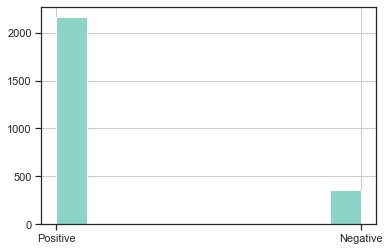

In [83]:
predictedReview1_df['predictions'].hist()
#histogram for the predicted values 

In [86]:
pr1_list = list(predictedReview1_df['predictions'])
pp1_count = pr1_list.count('Positive')
pn1_count = pr1_list.count('Negative')
print(pp1_count , pn1_count)

2162 356


In [87]:
X_text = movies_df['Texts']
Y = movies_df['Ratings_Class']

# Create a vectorizer that will track text as binary features
binary_vectorizer = CountVectorizer(binary=True)

# Let the vectorizer learn what tokens exist in the text data
binary_vectorizer.fit(X_text)

# Turn these tokens into a numeric matrix
X = binary_vectorizer.transform(X_text)

X

<12586x18589 sparse matrix of type '<class 'numpy.int64'>'
	with 271902 stored elements in Compressed Sparse Row format>

In [88]:
# Building Decision Tree Classifier

# Split X and Y into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.70)
# Create an empty, unlearned tree
tree = DecisionTreeClassifier(criterion="entropy")

# Fit/train the tree on the training data
tree.fit(X_train, Y_train)

# Get a prediction from the tree on the test data
Y_test_predicted = tree.predict(X_test)

# Get the accuracy of this prediction
accuracy = accuracy_score(Y_test_predicted, Y_test)

# Print the accuracy
print("The accuracy is " + str(accuracy))


The accuracy is 0.7163665254237288


In [89]:
# Doing Cross Validation

# Create an empty, unlearned tree
tree = DecisionTreeClassifier(criterion="entropy")
    
# This will get us 10-fold cross validation accuracy with our tree and our data
cross_fold_accuracies = cross_val_score(tree, X, Y, scoring="accuracy", cv=5)
    
# Average accuracy
average_cross_fold_accuracy = np.mean(cross_fold_accuracies)

for fold in cross_fold_accuracies:
    print(fold)

0.5976965845909452
0.5729042510925705
0.5887961859356377
0.66626936829559
0.601907032181168


In [90]:
print(confusion_matrix(Y_test, Y_test_predicted))
print(classification_report(Y_test, Y_test_predicted))

[[ 343  574]
 [ 497 2362]]
              precision    recall  f1-score   support

    Negative       0.41      0.37      0.39       917
    Positive       0.80      0.83      0.82      2859

    accuracy                           0.72      3776
   macro avg       0.61      0.60      0.60      3776
weighted avg       0.71      0.72      0.71      3776



In [91]:
movies_df1 = pd.DataFrame(X_test, columns=['Texts'])
predictedReview_df = movies_df1.assign(predictions=Y_test_predicted )

predictedReview_df.head(15)

,Texts,predictions
0,"(0, 746)\t1\n (0, 769)\t1\n (0, 1346)\t1\n...",Positive
1,"(0, 354)\t1\n (0, 627)\t1\n (0, 746)\t1\n ...",Positive
2,"(0, 220)\t1\n (0, 746)\t1\n (0, 1132)\t1\n...",Positive
3,"(0, 724)\t1\n (0, 746)\t1\n (0, 964)\t1\n ...",Negative
4,"(0, 230)\t1\n (0, 746)\t1\n (0, 769)\t1\n ...",Positive
5,"(0, 342)\t1\n (0, 2163)\t1\n (0, 2266)\t1\...",Positive
6,"(0, 1045)\t1\n (0, 1383)\t1\n (0, 4178)\t1...",Positive
7,"(0, 769)\t1\n (0, 2350)\t1\n (0, 3843)\t1\...",Positive
8,"(0, 858)\t1\n (0, 2349)\t1\n (0, 2991)\t1\...",Negative
9,"(0, 606)\t1\n (0, 719)\t1\n (0, 1477)\t1\n...",Positive


<AxesSubplot:>

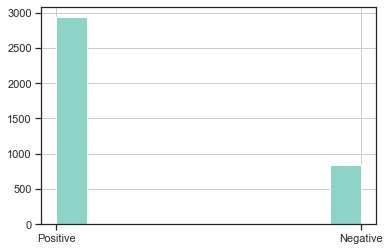

In [92]:
predictedReview_df['predictions'].hist()
#histogram for the predicted values 

In [94]:
pr_list = list(predictedReview_df['predictions'])
pp_count = pr_list.count('Positive')
pn_count = pr_list.count('Negative')
print(pp_count , pn_count)

3776
